# Neural SDE Practice

Defining Packages to Use: One major task will be to figure out which framework is best to use right now for our purposes. Tutorials can be outdated in this respect as warning messages show. The goal of this notebook is straightforward: to make NN approximators for the the drift (deterministic part) and diffusion (stochastic part) of a stochastic differential equation.

In [ ]:
# If Project.toml and Manifest.toml exist, remove them to start a completely fresh installation of packages and dependencies.
# This is equivalent to uninstalling all packages in the current environment. 
# Why? B/c if you don't start from a clean plate, and you have previous package dependency installation that were unspecified 
# below in their version number, then dependencies may conflict.

# get contents of working directory
dir_contents = readdir(".")
if "Manifest.toml" in dir_contents
    rm("Manifest.toml")
    println("Removed Manifest.toml from $(pwd()).")
end
if "Project.toml" in dir_contents
    rm("Project.toml")
    println("Removed Project.toml from $(pwd()).")
end

# Check file contents in project directory, copy over Project.toml and Manifest.toml if they exist.
# If they don't exist, create them with generate-project-toml.ipynb.
parentdir_contents = readdir("..")
parentdir_info = stat("..")
# copy contents from parent to working directory 
if "Manifest.toml" in parentdir_contents
    cp("../Manifest.toml", joinpath(pwd(),"Manifest.toml"))
    println("Manifest.toml copy from project dir to $(pwd()) successful.")
else
    println("No Manifest.toml in parent directory.")
end
if "Project.toml" in parentdir_contents
    cp("../Project.toml", joinpath(pwd(),"Project.toml"))
    println("Project.toml copy from project dir to $(pwd()) successful.")
else
    println("No Project.toml in parent directory.")
end

In [ ]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

In [3]:
using Plots, Statistics
using Flux, DiffEqFlux, StochasticDiffEq, DiffEqBase.EnsembleAnalysis

u0 = Float32[2.; 0.]
datasize = 30
tspan = (0.0f0, 1.0f0)
tsteps = range(tspan[1], tspan[2], length = datasize)

┌ Warning: Error requiring `Zygote` from `DiffEqBase`
│   exception =
│    LoadError: UndefVarError: ZygoteRules not defined
│    Stacktrace:
│      [1] top-level scope
│        @ :0
│      [2] include(mod::Module, _path::String)
│        @ Base .\Base.jl:419
│      [3] include(x::String)
│        @ DiffEqBase C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\DiffEqBase.jl:1
│      [4] macro expansion
│        @ C:\Users\ChemeGrad2021\.julia\packages\Requires\Z8rfN\src\Requires.jl:40 [inlined]
│      [5] top-level scope
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\init.jl:31
│      [6] eval
│        @ .\boot.jl:368 [inlined]
│      [7] eval
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\DiffEqBase.jl:1 [inlined]
│      [8] (::DiffEqBase.var"#76#100")()
│        @ DiffEqBase C:\Users\ChemeGrad2021\.julia\packages\Requires\Z8rfN\src\require.jl:101
│      [9] macro expansion
│        @ timing.jl:382 [inlined]
│     [10] err(f::An

┌ Warning: Error requiring `Tracker` from `DiffEqBase`
│   exception =
│    LoadError: UndefVarError: AbstractOverloadingSensitivityAlgorithm not defined
│    Stacktrace:
│      [1] getproperty(x::Module, f::Symbol)
│        @ Base .\Base.jl:31
│      [2] top-level scope
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\ext\DiffEqBaseTrackerExt.jl:64
│      [3] include(mod::Module, _path::String)
│        @ Base .\Base.jl:419
│      [4] include(x::String)
│        @ DiffEqBase C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\DiffEqBase.jl:1
│      [5] macro expansion
│        @ C:\Users\ChemeGrad2021\.julia\packages\Requires\Z8rfN\src\Requires.jl:40 [inlined]
│      [6] top-level scope
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\init.jl:27
│      [7] eval
│        @ .\boot.jl:368 [inlined]
│      [8] eval
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\DiffEqBase.jl:1 [inlined]
│      [9] (::DiffEqBase.var"#7

┌ Warning: Error requiring `ReverseDiff` from `DiffEqBase`
│   exception =
│    LoadError: UndefVarError: AbstractOverloadingSensitivityAlgorithm not defined
│    Stacktrace:
│      [1] getproperty(x::Module, f::Symbol)
│        @ Base .\Base.jl:31
│      [2] top-level scope
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\ext\DiffEqBaseReverseDiffExt.jl:65
│      [3] include(mod::Module, _path::String)
│        @ Base .\Base.jl:419
│      [4] include(x::String)
│        @ DiffEqBase C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\DiffEqBase.jl:1
│      [5] macro expansion
│        @ C:\Users\ChemeGrad2021\.julia\packages\Requires\Z8rfN\src\Requires.jl:40 [inlined]
│      [6] top-level scope
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\init.jl:29
│      [7] eval
│        @ .\boot.jl:368 [inlined]
│      [8] eval
│        @ C:\Users\ChemeGrad2021\.julia\packages\DiffEqBase\VDPJ8\src\DiffEqBase.jl:1 [inlined]
│      [9] (::DiffEqBas

0.0f0:0.03448276f0:1.0f0

A stochastic differential equation can be written as
$$dx = f(t,x)dt+g(t,x)dW$$
Where x is Nx1, f is Nx1, W is a set of brownian noise processes of dimension Px1, and g is accordingly a matrix of size NxP. The cell below generates training data and defines the functions f and g respectively. One important note: a common assumption for modeling these systems is to have each differential variable have its own associated noise component. Mathematically, this means that N=P and g is a diagonal matrix. This explains why true_noise_func produces only a vector as a shorthand.

Our project is based around assuming structure in g, so we will not be doing this. 

In [4]:
function trueSDEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

mp = Float32[0.2, 0.2]
function true_noise_func(du, u, p, t)
    du .= mp.*u
end

prob_truesde = SDEProblem(trueSDEfunc, true_noise_func, u0, tspan)
nothing

Plotting some individual curves just for fun

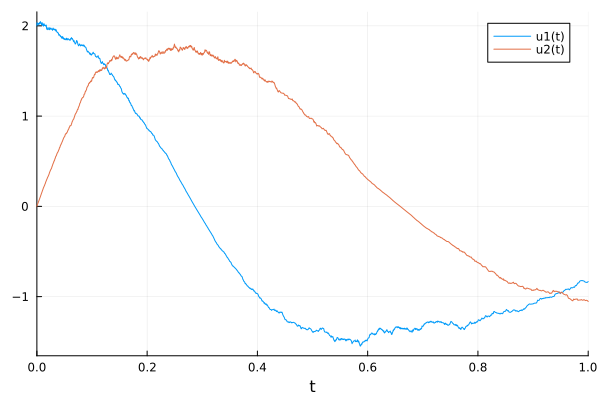

In [5]:
plotting_sol = solve(prob_truesde, SOSRI())
plot(plotting_sol)

Now generate a set of solutions - our training data will be the means and variances of the dataset. 

In [6]:
# Take a typical sample from the mean
ensemble_prob = EnsembleProblem(prob_truesde)
ensemble_sol = solve(ensemble_prob, SOSRI(), trajectories = 10000)
ensemble_sum = EnsembleSummary(ensemble_sol)

sde_data, sde_data_vars = Array.(timeseries_point_meanvar(ensemble_sol, tsteps))
nothing

This is a basic structure for the neural SDE: define two different neural networks - note that they include some deterministic parts in the form of the first layer of the drift network. We may think about ways to do this wrt the chemical sciences. Here they use NeuralDSDE - the extra D stands for "Diagonal", meaning that the g matrix explained above has to be diagonal. For our purposes there is another related solver - NeuralSDE. It seems that NeuralSDE will be a great tool for what we are trying to do, but I am not sure if there are other options availible. 

In [7]:
drift_dudt = FastChain((x, p) -> x.^3,
                       FastDense(2, 50, tanh),
                       FastDense(50, 2))
diffusion_dudt = FastChain(FastDense(2, 2))

neuralsde = NeuralDSDE(drift_dudt, diffusion_dudt, tspan, SOSRI(),
                       saveat = tsteps, reltol = 1e-1, abstol = 1e-1)
nothing

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux C:\Users\ChemeGrad2021\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux C:\Users\ChemeGrad2021\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9


Flux.jl uses random weights to initialize NN's. Here they run the NSDE and plot against data - mostly to show that it does not fit. This whole process is the first hint that training will be a slow process - one loss evaluation in this case requires a large number of ODE solves to generate means and variances. 

In [8]:
# Get the prediction using the correct initial condition
prediction0 = neuralsde(u0)

drift_(u, p, t) = drift_dudt(u, p[1:neuralsde.len])
diffusion_(u, p, t) = diffusion_dudt(u, p[(neuralsde.len+1):end])

prob_neuralsde = SDEProblem(drift_, diffusion_, u0,(0.0f0, 1.2f0), neuralsde.p)

ensemble_nprob = EnsembleProblem(prob_neuralsde)
ensemble_nsol = solve(ensemble_nprob, SOSRI(), trajectories = 100,
                      saveat = tsteps)
ensemble_nsum = EnsembleSummary(ensemble_nsol)

plt1 = plot(ensemble_nsum, title = "Neural SDE: Before Training")
scatter!(plt1, tsteps, sde_data', lw = 3)

scatter(tsteps, sde_data[1,:], label = "data")
scatter!(tsteps, prediction0[1,:], label = "prediction")
nothing

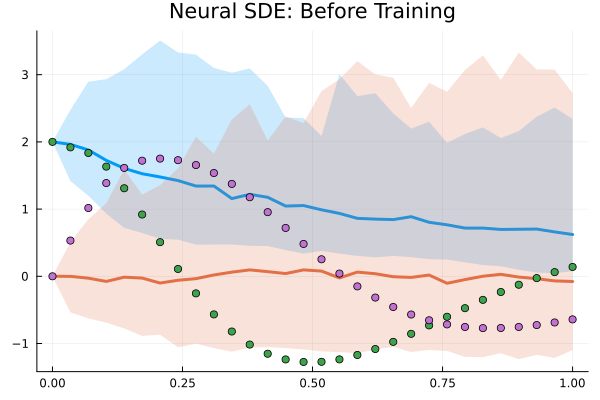

In [9]:
plt1 = plot(ensemble_nsum, title = "Neural SDE: Before Training")
scatter!(plt1, tsteps, sde_data', lw = 3)

Training takes place in two phases - why they knew to do this is unclear. Either way, it takes an immense amount of time. It is unclear how the process can be sped up. 

In [32]:
function predict_neuralsde(p)
  return Array(neuralsde(u0, p))
end

function loss_neuralsde(p; n = 100)
  samples = [predict_neuralsde(p) for i in 1:n]
  means = reshape(mean.([[samples[i][j] for i in 1:length(samples)]
                                        for j in 1:length(samples[1])]),
                      size(samples[1])...)
  vars = reshape(var.([[samples[i][j] for i in 1:length(samples)]
                                      for j in 1:length(samples[1])]),
                      size(samples[1])...)
  loss = sum(abs2, sde_data - means) + sum(abs2, sde_data_vars - vars)
  return loss, means, vars
end
nothing

In [33]:
list_plots = []
iter = 0

# Callback function to observe training
callback = function (p, loss, means, vars; doplot = false)
  global list_plots, iter

  if iter == 0
    list_plots = []
  end
  iter += 1

  # loss against current data
  display(loss)

  # plot current prediction against data
  plt = scatter(tsteps, sde_data[1,:], yerror = sde_data_vars[1,:],
                ylim = (-4.0, 8.0), label = "data")
  scatter!(plt, tsteps, means[1,:], ribbon = vars[1,:], label = "prediction")
  push!(list_plots, plt)

  if doplot
    display(plt)
  end
  return false
end
nothing

In [34]:
opt = ADAM(0.025)

# First round of training with n = 10
result1 = DiffEqFlux.sciml_train((p) -> loss_neuralsde(p, n = 10),  
                                 neuralsde.p, opt,
                                 cb = callback, maxiters = 100)

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux C:\Users\ChemeGrad2021\.julia\packages\DiffEqFlux\2IJEZ\src\train.jl:6


242.48639f0

154.46155f0

116.93228f0

106.14664f0

97.43872f0

94.25998f0

92.24497f0

85.994514f0

78.69465f0

79.74127f0

77.10605f0

72.4421f0

66.050995f0

65.29018f0

61.752167f0

52.481525f0

63.3525f0

70.47618f0

55.30881f0

54.872948f0

51.758507f0

30.288155f0

252.70305f0

96.360245f0

35.417503f0

50.33531f0

430.406f0

34.291164f0

41.742546f0

49.640396f0

37.28853f0

31.537296f0

35.582916f0

54.19621f0

38.75908f0

46.051956f0

49.11111f0

44.94393f0

483.04996f0

51.60053f0

37.265133f0

47.37963f0

45.713223f0

88.58249f0

40.78563f0

40.513344f0

51.658867f0

45.102867f0

23.653608f0

39.81399f0

95.57119f0

42.311436f0

20.55914f0

750.1009f0

17.915955f0

20.72126f0

27.519676f0

35.8849f0

29.569239f0

22.521145f0

18.710651f0

39.431683f0

25.890503f0

38.892765f0

59.20453f0

27.398495f0

21.84064f0

35.37195f0

34.618378f0

30.709797f0

32.939934f0

24.605762f0

30.773903f0

38.23905f0

43.619415f0

48.53547f0

33.06183f0

35.814632f0

36.60887f0

51.02095f0

36.834248f0

42.476997f0

24.672031f0

43.69226f0

43.073048f0

29.58833f0

37.88833f0

37.56508f0

40.060833f0

33.93468f0

33.70444f0

23.488459f0

26.46615f0

39.93841f0

21.808699f0

24.469492f0

27.692814f0

16.447645f0

25.145279f0

27.096592f0

16.447645f0

u: 258-element Vector{Float32}:
 -0.44701877
  0.21374877
 -0.100164935
  0.037088662
  0.340854
  0.20312834
  0.38869968
  0.28623125
 -0.11195735
  0.048247233
  0.53297406
 -0.50371706
  0.19228235
  ⋮
  0.53647345
 -0.15782693
 -0.09811135
  0.16991882
 -0.3433203
 -0.2460563
  0.86644423
  0.7417986
  0.49756414
  0.34970537
  0.21537873
 -0.6808065

In [35]:
result2 = DiffEqFlux.sciml_train((p) -> loss_neuralsde(p, n = 100),
                                 result1.minimizer, opt,
                                 cb = callback, maxiters = 100)

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux C:\Users\ChemeGrad2021\.julia\packages\DiffEqFlux\2IJEZ\src\train.jl:6


23.155949f0

14.864796f0

10.96383f0

37.741005f0

10.81929f0

6.8509636f0

14.814352f0

13.10809f0

20.694866f0

14.254698f0

19.68486f0

24.114933f0

25.020306f0

24.156715f0

25.543304f0

26.714352f0

25.147951f0

30.12707f0

26.665169f0

27.824772f0

25.541365f0

27.387909f0

23.258894f0

24.593594f0

27.01889f0

28.684374f0

24.92173f0

22.943295f0

24.620798f0

25.201675f0

22.53072f0

19.172436f0

21.966335f0

19.629284f0

18.784138f0

18.446693f0

17.615047f0

15.287912f0

19.575525f0

12.975792f0

13.108585f0

15.45072f0

12.021781f0

11.693719f0

11.287568f0

11.185391f0

10.773114f0

9.637345f0

9.689815f0

9.837215f0

10.722064f0

9.3892975f0

8.74445f0

8.827053f0

12.049757f0

10.314473f0

10.105248f0

9.040425f0

9.370146f0

10.338582f0

10.205612f0

10.184208f0

7.600201f0

7.4526186f0

8.787998f0

6.8140516f0

6.9737687f0

8.61693f0

6.666991f0

7.6895475f0

6.7094765f0

9.167404f0

6.982542f0

6.042534f0

7.834663f0

8.669966f0

7.219617f0

5.056958f0

6.26266f0

7.6767077f0

7.611597f0

18.255342f0

6.5691648f0

6.3927965f0

6.292693f0

9.953906f0

6.214404f0

5.7415924f0

6.0709534f0

6.6736975f0

4.5509086f0

5.5904865f0

4.2845454f0

4.8533897f0

9.826092f0

4.5710607f0

3.3537998f0

20.963537f0

6.5094957f0

3.849854f0

3.3537998f0

u: 258-element Vector{Float32}:
 -0.40900904
  0.15884796
 -0.082203776
  0.112532444
  0.29275647
  0.23489337
  0.17464691
  0.23077404
 -0.17119281
  0.063447095
  0.40438133
 -0.39905265
  0.13458215
  ⋮
  0.5000552
 -0.20075361
 -0.069440395
  0.19156976
 -0.23909317
 -0.26597148
  0.8320304
  0.7971476
  0.47624555
  0.21526223
  0.21605794
 -1.2845944

In [10]:
result2

LoadError: UndefVarError: result2 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [36]:
samples = [predict_neuralsde(result2.minimizer) for i in 1:1000]
means = reshape(mean.([[samples[i][j] for i in 1:length(samples)]
                                      for j in 1:length(samples[1])]),
                    size(samples[1])...)
vars = reshape(var.([[samples[i][j] for i in 1:length(samples)]
                                    for j in 1:length(samples[1])]),
                    size(samples[1])...)

plt2 = scatter(tsteps, sde_data', yerror = sde_data_vars',
               label = "data", title = "Neural SDE: After Training",
               xlabel = "Time")
plot!(plt2, tsteps, means', lw = 8, ribbon = vars', label = "prediction")

plt = plot(plt1, plt2, layout = (2, 1))
savefig(plt, "NN_sde_combined.png"); nothing # sde

The final result: Our NN's can approximate both the means and the variances of the data. 

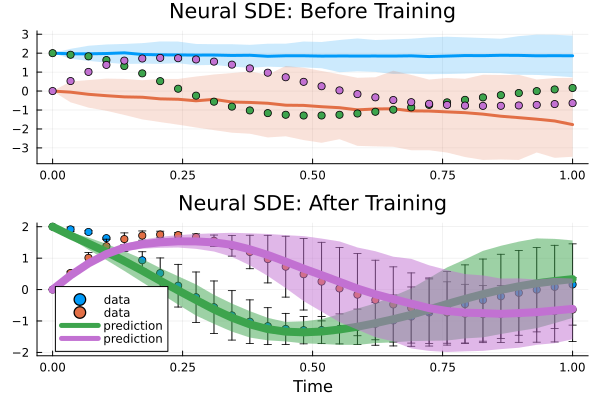

In [38]:
plt